In [4]:
import re, pprint

import pymupdf
from PIL import Image

# Parsing DeleteMe Reports with PyMuPDF

I chose this pdf as it's particularly difficult in terms of structure. The PDF uses tinted rects to shade out certain text instead of setting a colour. The links are not exactly structured correctly, which trips up some PDF libraries. PyMuPDF requires MuPDF to be installed but works really well at digging things out.

In [5]:
fn = './privacy-report.pdf'
doc = pymupdf.open(fn)
doc.page_count

12

## Reviewing Content

I prefer pdfplumber's bounding box approach which makes it really easy to see what you're doing. PyMuPDF is a bit tougher to deal with. Basically you have to generate a pixmap, convert this to a PIL image and then display it. It's not the end of the world as generally you won't be generating images in a fully automated parser.

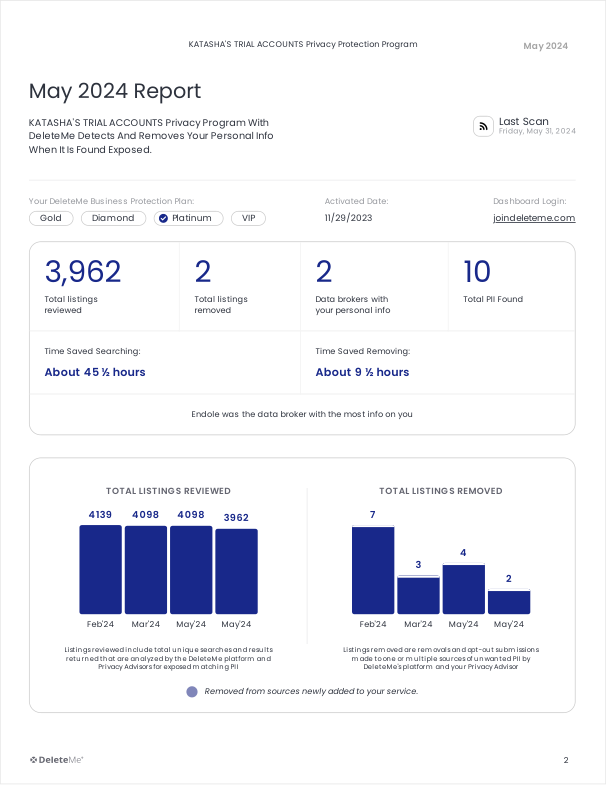

In [8]:
page = doc[2] # Select Page 2

def pix2img(buf, clip = None):
    if clip == None:
        pix = buf.get_pixmap() # Generate Pixmap
    else:
        pix = buf.get_pixmap(clip=clip)
    mode = "RGBA" if pix.alpha else "RGB" # Set the colour mode based on whether or not there's an alpha layer
    img = Image.frombytes(mode, [pix.width, pix.height], pix.samples) # Generate a PIL Image
    return img # Return PIL Image

img = pix2img(page)
img

## Extracting Initial Listings Data

There are two pieces of data that we want to extract from page 2:

1. Last Scan date (see top right)
2. Listing stats (middle third of page)

PyMuPDF Has many ways to do this, but I've found the easiest approach is to define a bounding box ("Rect" in PyMuPDF speak) and extract from there.

A rect is a 4 integer tuple with the following values, in order:

- x0 - Left edge
- y0 - Top edge
- x1 - Right edge
- y1 - Bottom edge

The values are stored in dots, normaly 72 dpi by default.

In [9]:
# Lets get report date
page = doc[2]

rect = (500, 130, 600, 140)
report_date = page.get_textbox(rect)
print(report_date)

Friday, May 31, 2024


In [10]:
# Lets get the data

# I'm selecting page 2 again in case I run this cell out of sequence
page = doc[2]
rect = (0, 250, 600, 280)
listings = doc[2].get_textbox(rect).split('\n')

#p2list = p2.extract_text().split('\n')
#report_date = p2list[3]
#listings = p2list.split(' ')
summary = {
    'total_listings_reviewed': listings[0].replace(',',''),
    'total__listings_removed': listings[1],
    'brokers_with_pii': listings[2],
    'total_pii_found': listings[3]
}
data = {
    'report_date': report_date,
    'summary': summary,
}
data

{'report_date': 'Friday, May 31, 2024',
 'summary': {'total_listings_reviewed': '3962',
  'total__listings_removed': '2',
  'brokers_with_pii': '2',
  'total_pii_found': '10'}}

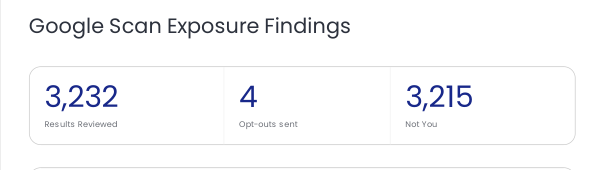

In [11]:
r = pymupdf.Rect(0,80,600,250)
pix2img(doc[3], r)

## Getting Google Info From Page 3
Page 3 Focuses on what DeleteMe's found in Google searches. What we're really interested in is that top section.

In [12]:
# Set page to doc[3] in case cells are run out of order
page = doc[3]
r = pymupdf.Rect(20,160,612,190)

results = page.get_textbox(r).replace(',','').split('\n')
results

google_scan = {
    'results_reviewed': results[0],
    'opt_outs_sent': results[1],
    'not_user': results[2],
}
data['google_scan_exposure_findings'] = google_scan
data

#pix2img(page, r)

{'report_date': 'Friday, May 31, 2024',
 'summary': {'total_listings_reviewed': '3962',
  'total__listings_removed': '2',
  'brokers_with_pii': '2',
  'total_pii_found': '10'},
 'google_scan_exposure_findings': {'results_reviewed': '3232',
  'opt_outs_sent': '4',
  'not_user': '3215'}}

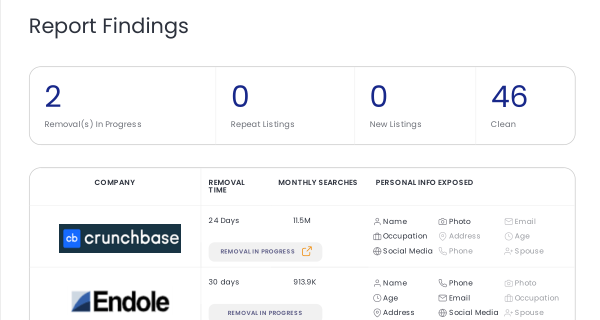

In [13]:
r = pymupdf.Rect(0,80,600,400)
pix2img(doc[5],r)

## Page 5 Removal Findings

The report proper starts on page 5 and lists all of the data broker sites DeleteMe are trying to or have already removed. Parsing that lower table requires getting into OCR, which is beyond the remit of the talk but is on the TODO list. That top bit is fair game.

In [14]:
# Set page to doc[5] in case cells are run out of order
page = doc[5]
r = pymupdf.Rect(20,160,612,190)

report_findings = page.get_textbox(r).replace(',','').split('\n')

findings = {
    'in_progress': report_findings[0],
    'repeat_listings': report_findings[1],
    'new_listings': report_findings[2],
    'clean': report_findings[3],
}
data['report_findings'] = findings
data

#pix2img(page, r)

{'report_date': 'Friday, May 31, 2024',
 'summary': {'total_listings_reviewed': '3962',
  'total__listings_removed': '2',
  'brokers_with_pii': '2',
  'total_pii_found': '10'},
 'google_scan_exposure_findings': {'results_reviewed': '3232',
  'opt_outs_sent': '4',
  'not_user': '3215'},
 'report_findings': {'in_progress': '2',
  'repeat_listings': '0',
  'new_listings': '0',
  'clean': '46'}}

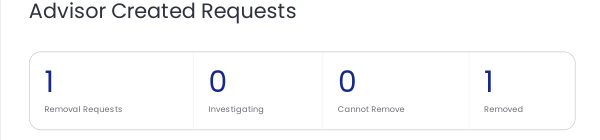

In [15]:
r = pymupdf.Rect(0,80,600,220)
pix2img(doc[-1],r)

## Last Page, Advisor Created Requests

The last page contains submitted requests for removal. As before there's a small header section containing data to be extracted.

In [16]:
# Set page to doc[-1] in case cells are run out of order
page = doc[-1]
r = pymupdf.Rect(20,140,612,180)

advisor_stats = page.get_textbox(r).replace(',','').split('\n')
advisor_stats
removal_requests, investigating, cant_remove, removed = advisor_stats

advisor_stats = {
    'removal_requests': removal_requests,
    'investigating': investigating,
    'cant_remove': cant_remove,
    'removed': removed,
}
data['advisor_stats'] = advisor_stats
data

#pix2img(page, r)

{'report_date': 'Friday, May 31, 2024',
 'summary': {'total_listings_reviewed': '3962',
  'total__listings_removed': '2',
  'brokers_with_pii': '2',
  'total_pii_found': '10'},
 'google_scan_exposure_findings': {'results_reviewed': '3232',
  'opt_outs_sent': '4',
  'not_user': '3215'},
 'report_findings': {'in_progress': '2',
  'repeat_listings': '0',
  'new_listings': '0',
  'clean': '46'},
 'advisor_stats': {'removal_requests': '1',
  'investigating': '0',
  'cant_remove': '0',
  'removed': '1'}}

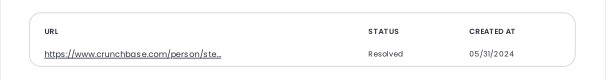

In [99]:
r = pymupdf.Rect(0,220,612,300)
pix2img(doc[-1],r)

### URLs

On the same page is a list of URLs and their status. "Resolved" Doesn't actually imply a course of action, just that they've closed their investigation *shrug* but the URL and Created At dates may be useful. The text doesn't supply the full link, so we're going to have to try and map that across.

In [100]:
page = doc[-1]
clip = pymupdf.Rect(0,220,600,300)
tabs = page.find_tables(clip=clip, horizontal_strategy="text", vertical_strategy="text")
for i,tab in enumerate(tabs):  # iterate over all tables
    for cell in tab.header.cells:
        page.draw_rect(cell,color=pymupdf.pdfcolor["red"],width=0.3)
    page.draw_rect(tab.bbox,color=pymupdf.pdfcolor["green"])
    print(f"Table {i} column names: {tab.header.names}, external: {tab.header.external}")


In [101]:
tabs = page.find_tables(horizontal_strategy="text", vertical_strategy="text")
tab = tabs[0]
tab.header.names

["KATASHA'S TRIAL ACCOUNTS Privacy", 'Protection Program', '', 'May']